In [1]:
import sys
sys.path.append('..')
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import pandana as pdn
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import my_functions as mf
import warnings
import os
import json
from shapely.geometry import Point

warnings.filterwarnings("ignore")

In [3]:
categories = ['Aprovisionamiento', 'Entretenimiento', 'Servicios', 'Comida para servir', 'Transporte publico', 'Cuidados', 'Educacion']

In [3]:
crs = 4326
gdf = gpd.read_file('/app/data/output/amenities_maps/Aprovisionamiento').to_crs(crs)
filter_area = gpd.read_file('/app/data/input/limite_urbano_ccp_utm').to_crs(crs)

# Filtrar los puntos de interes que estén solo en el radio urbano
gdf = gpd.sjoin(gdf, filter_area, op='within')

<Axes: >

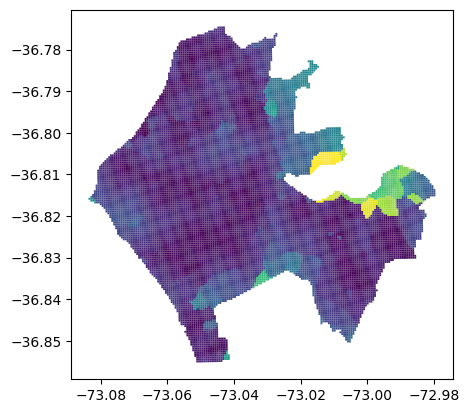

In [4]:
gdf.plot(column='travel_tim')

In [6]:
import matplotlib.colors as mcolors

map_cols = ['grid_id', 'Category', 'travel_time']

def load_gdf_category(category):
    crs = 4326
    cat = category.replace(' ', '_')
    gdf = gpd.read_file(f'/app/data/output/amenities_maps/{cat}').to_crs(crs)
    filter_area = gpd.read_file('/app/data/input/limite_urbano_ccp_utm').to_crs(crs)
    # Filtrar los puntos de interes que estén solo en el radio urbano
    gdf = gpd.sjoin(gdf, filter_area, op='within')
    if('travel_time' not in gdf):
        gdf.rename(columns={'travel_tim': 'travel_time'}, inplace=True)
    return gdf

def export_shape_map(gdf, category):
    exp_category = category.replace(' ', '_')
    exp_cols = ['grid_id', 'travel_time', 'geometry']
    gdf[exp_cols].to_file(f'/app/data/output/amenities_maps/{exp_category}_filter')
    pass

def draw_map(gdf, category):
    exp_category = category.replace(' ', '_')
    (h, w) = (20, 20)
    fig, ax = plt.subplots(figsize=(h, w))

    # Rango deseado para la escala de colores
    vmin = 0
    vmax = 30
    cmap = 'RdYlGn_r'  # Utilizamos el colormap 'RdYlBu'

    # Normalizar los valores de 'travel_time' para asegurar que estén dentro del rango de colores
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    # Plotear las geometrías con los colores según 'travel_time'
    gdf.plot(ax=ax, column='travel_time', cmap=cmap, linewidth=0.8, edgecolor='none', norm=norm, alpha=0.5)

    # Ajustar la escala de la barra de colores
    cbar = fig.colorbar(mapper, shrink=0.5)
    cbar.set_label('Travel Time (minutes)', size=20)  # Etiqueta de la barra de colores
    ticks = np.arange(vmin, vmax+1, 5)
    cbar.set_ticks(ticks)  # Puedes personalizar los ticks de la barra
    str_ticks = [str(n) for n in ticks]
    str_ticks[-1] = f'{vmax}+'
    cbar.set_ticklabels(str_ticks)  # Personalizar los valores de los ticks
    cbar.ax.tick_params(labelsize=20)

    # Agrega un mapa de fondo utilizando contextily
    ctx.add_basemap(
        ax=ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs=gdf.crs.to_string(),
        alpha=0.7
    )
    plt.title(f'Mapa de accesibilidad en {category}', size=30)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'/app/data/output/amenities_maps/imgs/{exp_category}_filter.png')

# for category in categories:
#     try:
#         gdf = load_gdf_category(category)
#         export_shape_map(gdf, category)
#         draw_map(gdf, category)
#     except:
#         print(f'Error en categoria {category}')
#     # plt.show()

In [7]:
gdfs = {}
for category in categories:
    gdf = load_gdf_category(category)
    gdfs[category] = gdf

In [8]:
for index, cat in enumerate(categories):
    gdf = gdfs[cat]
    gdf.rename(columns={'travel_time': cat}, inplace=True)
    map_cols = ['grid_id', cat]
    gdf = gdf[map_cols]
    if index==0:
        gdf_out = gdf
    else:
        gdf_out = pd.merge(gdf_out, gdf, on='grid_id')
# gdf['Category'] = cat
# gdf[map_cols]
# for c in category[1:]:
#     gdf = pd.merge(gdfs['Aprovisionamiento'].rename(columns={'travel_time':'Aprovisionamiento'}),
#          gdfs['Servicios'].rename(columns={'travel_time':'Servicios'}),
#          on='grid_id')

In [9]:
gdf_out['Tiempo Promedio'] = gdf_out[categories].mean(axis=1)

In [10]:
grid = gpd.read_file('/app/data/input/grilla50_urbano_extendido').to_crs(4326)
# Ajuste de la grilla y sus 'id'
grid.drop(['Id'], axis='columns', inplace=True)
grid['grid_id'] = grid.index

In [11]:
grid = grid[grid['grid_id'].isin(gdf_out['grid_id'])]

In [12]:
gdf_out = pd.merge(gdf_out, grid, on='grid_id')

In [13]:
del gdf
gdf = gpd.GeoDataFrame(data=gdf_out.drop(columns=['geometry']), geometry=gdf_out['geometry']).to_crs(4326)

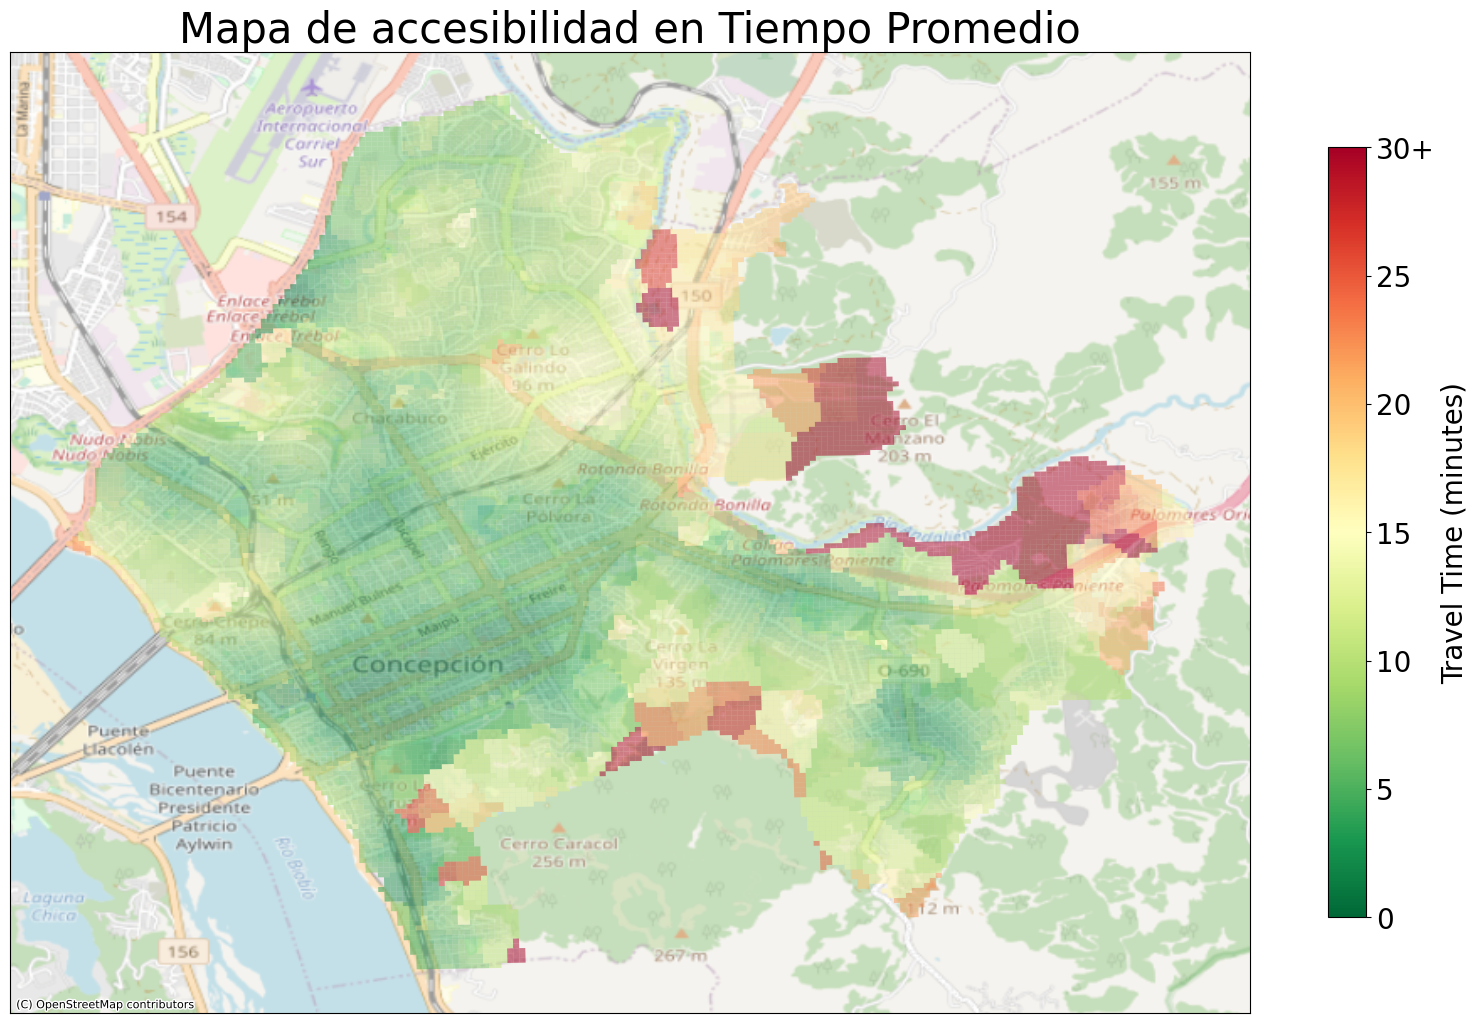

In [12]:
category = 'Tiempo Promedio'
exp_category = category.replace(' ', '_')
(h, w) = (20, 20)
fig, ax = plt.subplots(figsize=(h, w))

# Rango deseado para la escala de colores
vmin = 0
vmax = 30
cmap = 'RdYlGn_r'  # Utilizamos el colormap 'RdYlBu'

# Normalizar los valores de 'travel_time' para asegurar que estén dentro del rango de colores
norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plotear las geometrías con los colores según 'travel_time'
gdf.plot(ax=ax, column='Tiempo Promedio', cmap=cmap, linewidth=0.8, edgecolor='none', norm=norm, alpha=0.5)

# Ajustar la escala de la barra de colores
cbar = fig.colorbar(mapper, shrink=0.5)
cbar.set_label('Travel Time (minutes)', size=20)  # Etiqueta de la barra de colores
ticks = np.arange(vmin, vmax+1, 5)
cbar.set_ticks(ticks)  # Puedes personalizar los ticks de la barra
str_ticks = [str(n) for n in ticks]
str_ticks[-1] = f'{vmax}+'
cbar.set_ticklabels(str_ticks)  # Personalizar los valores de los ticks
cbar.ax.tick_params(labelsize=20)

# Agrega un mapa de fondo utilizando contextily
ctx.add_basemap(
    ax=ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs=gdf.crs.to_string(),
    alpha=0.7
)
plt.title(f'Mapa de accesibilidad en {category}', size=30)
plt.xticks([])
plt.yticks([])
plt.savefig(f'/app/data/output/amenities_maps/imgs/{exp_category}_filter.png')

In [18]:
gdf.to_file('/app/data/output/amenities_maps/Resumen')

In [19]:
gdf.columns

Index(['grid_id', 'Aprovisionamiento', 'Entretenimiento', 'Servicios',
       'Comida para servir', 'Transporte publico', 'Cuidados', 'Educacion',
       'Tiempo Promedio', 'geometry'],
      dtype='object')

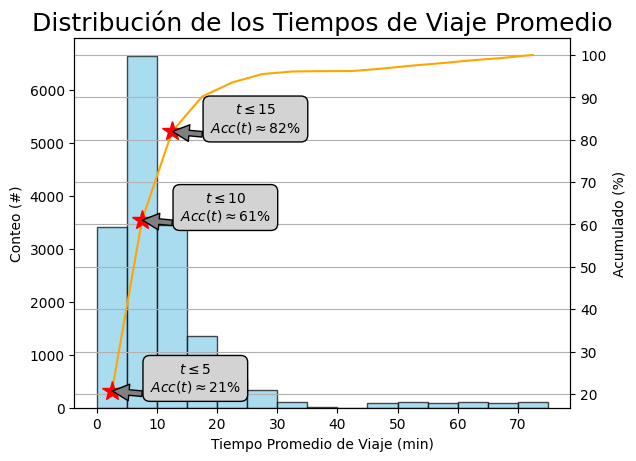

In [74]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

def find_nearest(array_1, array_2, value):
    # Ensure the inputs are numpy arrays
    array_1 = np.array(array_1)
    array_2 = np.array(array_2)

    # Calculate the absolute difference between each element in array_1 and the target value
    differences = np.abs(array_1 - value)
    
    # Get the index of the smallest difference
    index = np.argmin(differences)
    
    # Return the corresponding element from array_2
    return array_2[index]

# Supongamos que tu GeoDataFrame se llama 'gdf'

# Define las amenidades
amenities = ['Aprovisionamiento', 'Entretenimiento', 'Servicios',
       'Comida para servir', 'Transporte publico', 'Cuidados', 'Educacion',
       'Tiempo Promedio']

# Get the statistical summary
summary = gdf.describe()
summary = summary[amenities]
# print(summary.transpose())

# Define the time thresholds
thresholds = [15, 10, 5]

# Calculate the percentage of areas that are within each threshold for each amenity
percentages = {}

# for amenity in amenities:
#     percentages[amenity] = []
#     for threshold in thresholds:
#         percentage = (gdf[amenity] < threshold).mean() * 100
#         percentages[amenity].append(percentage)

# # Print the percentages
# for amenity in amenities:
#     print(f"--- {amenity} ---")
#     for i, threshold in enumerate(thresholds):
#         print(f"Less than {threshold} minutes: {percentages[amenity][i]}%")
#     print()

step = 5
# Define bins and calculate histogram
bins = np.arange(0, gdf['Tiempo Promedio'].max() + step, step)
hist, bin_edges = np.histogram(gdf['Tiempo Promedio'], bins=bins, density=True)

# Calculate cumulative distribution function (CDF)
cdf = np.cumsum(hist * np.diff(bin_edges))

# Create two subplots sharing x-axis
fig, ax1 = plt.subplots()

# Plot histogram without normalization
ax1.hist(gdf['Tiempo Promedio'], bins=bins, alpha=0.7, color='skyblue', edgecolor='black')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot CDF
ax2.plot(bin_edges[:-1]+step/2, cdf * 100, color='orange')  # Multiply by 100 to convert to percentage

min_time = 0
max_time = 15
times = np.arange(min_time, max_time, step)
# Add markers at specific points
for x in times:
    # Get the index of the bin edge that is closest to x
    idx = (np.abs(bin_edges - x)).argmin()

    # Adjust index if necessary to ensure marker is placed on the CDF line
    if bin_edges[idx] < x and idx < len(cdf) - 1:
        idx += 1

    # Plot the marker at the CDF value at idx
    ax2.plot(x+step/2, cdf[idx] * 100, marker='*', color='red', markersize=15)  # Multiply by 100 to convert to percentage

    # Add a text box with an arrow indicating the time and accumulated value
    ax2.annotate(f"$t \leq {x+5}$\n$Acc(t) \\approx {cdf[idx]*100:.0f}\%$",
                 (x+step/2, cdf[idx]*100),
                 textcoords="offset points", xytext=(60,0),
                 ha='center', arrowprops=dict(facecolor='gray', shrink=0.01),
                 bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))

# Set labels and title
ax1.set_xlabel('Tiempo Promedio de Viaje (min)')
ax1.set_ylabel('Conteo (#)')
ax2.set_ylabel('Acumulado (%)')  # Indicate that the CDF is in percentage
plt.title('Distribución de los Tiempos de Viaje Promedio', fontdict={'size':18})

# Remove legends
# ax1.get_legend().remove()
# ax2.get_legend().remove()

# Add grid
plt.grid()

# Show the plot
plt.show()


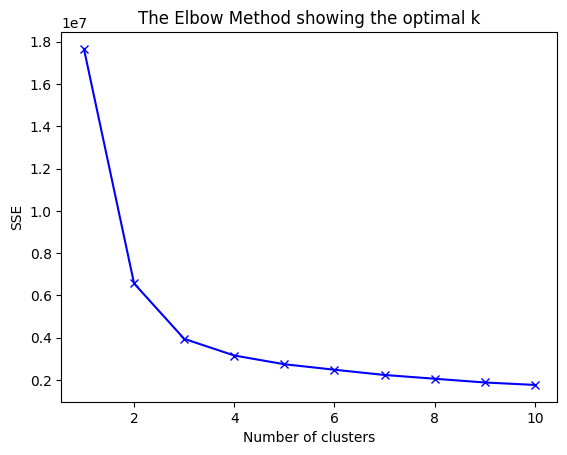

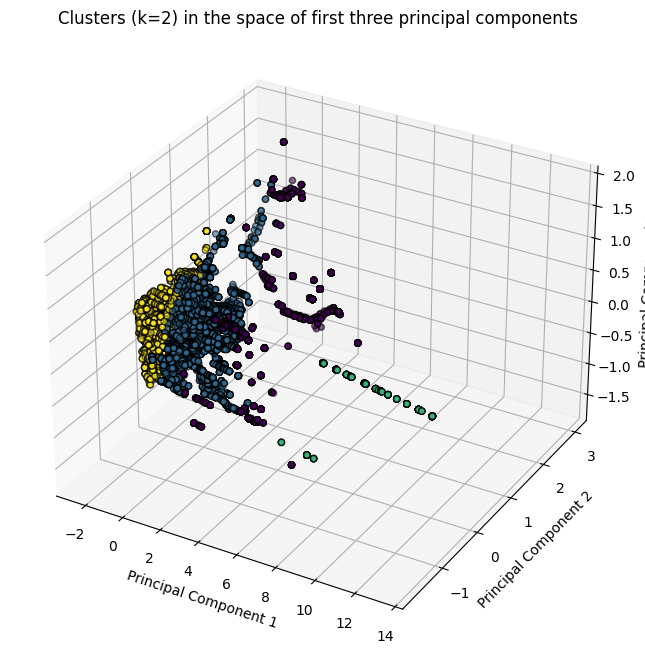

In [77]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 1. Generate feature matrix
features = ['Aprovisionamiento', 'Entretenimiento', 'Servicios',
            'Comida para servir', 'Transporte publico', 'Cuidados', 'Educacion']
X = gdf[features].values

# 2. Apply KMeans and calculate SSE for different number of clusters
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_  # Inertia: Sum of distances of samples to their closest cluster center

# 3. Plot elbow method
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Identify the elbow point programmatically 
k_values = list(sse.keys())
sse_values = list(sse.values())
elbow_point = k_values[np.diff(sse_values).argmin() + 1]
n_clusters = 4

# 4. Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
kmeans.fit(X)
labels = kmeans.labels_

# 5. Reduce to 3D using PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_scaled)

# 6. Plot clusters in 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principalComponents[:, 0], principalComponents[:, 1], principalComponents[:, 2], 
           c=labels, edgecolor='k', alpha=0.6)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title(f'Clusters (k={elbow_point}) in the space of first three principal components')
plt.show()


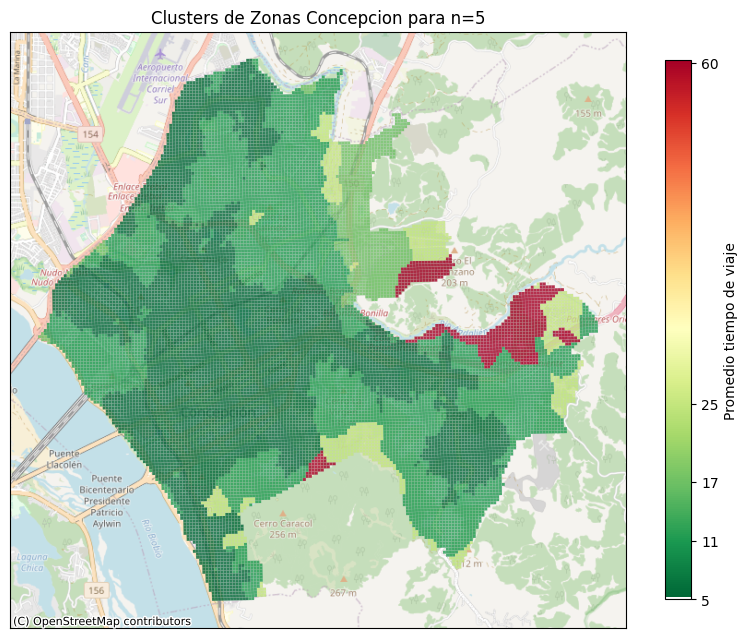

In [151]:
import contextily as ctx
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Generate feature matrix
features = ['Aprovisionamiento', 'Entretenimiento', 'Servicios',
            'Comida para servir', 'Transporte publico', 'Cuidados', 'Educacion']
X = gdf[features].values

# 2. Apply KMeans with specified number of clusters
n_clusters = 5

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Apply KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
kmeans.fit(X)
labels = kmeans.labels_

# Add cluster labels to dataframe
gdf['cluster'] = labels

# Compute mean travel time per cluster
cluster_means = gdf.groupby('cluster')['Tiempo Promedio'].mean()

# Round mean travel times to nearest integer
cluster_means_rounded = np.round(cluster_means)

# Create color map (from green to red) based on mean travel time
cmap = plt.get_cmap('RdYlGn_r')
norm = plt.Normalize(cluster_means.min(), cluster_means.max())
colors = cmap(norm(cluster_means))

# Create a dictionary mapping from cluster label to color
color_dict = dict(zip(cluster_means.index, colors))

# Convert to Web Mercator CRS for contextily
gdf_web_mercator = gdf.to_crs(epsg=3857)

# Plot clusters on map, colored by mean travel time
gdf_web_mercator['color'] = gdf_web_mercator['cluster'].map(color_dict)
gdf_web_mercator.plot(color=gdf_web_mercator['color'], linewidth=0.1, ax=ax, edgecolor='0.8', alpha=0.8)

# Set title
ax.set_title(f'Clusters de Zonas Concepcion para n={n_clusters}')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.7)

# Create colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='Promedio tiempo de viaje', shrink=0.7)
cbar.set_ticks(cluster_means_rounded)
cbar.set_ticklabels(cluster_means_rounded.astype(int))

ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.tight_layout()
plt.show()


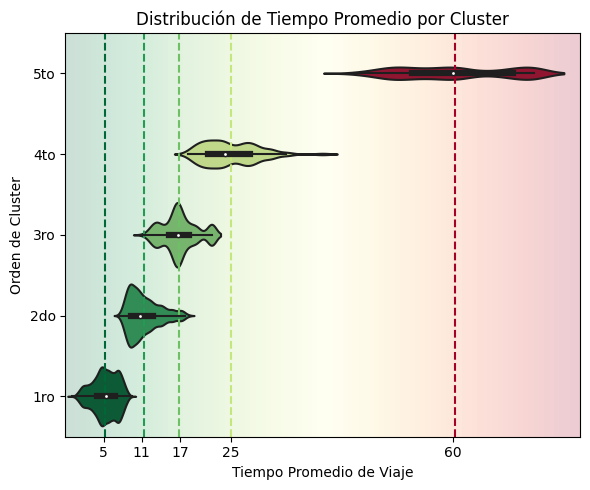

In [228]:
import seaborn as sns
import numpy as np

# Define cluster names in descending order
cluster_names = {0: "5to", 1: "4to", 2: "3ro", 3: "2do", 4: "1ro"}

# Sort cluster_means and get sorted indices
sorted_indices = cluster_means.sort_values(ascending=False).index

# Map sorted indices to cluster names
name_dict = {idx: name for idx, name in zip(sorted_indices, cluster_names.values())}

# Create a new column for cluster names
gdf['cluster_name'] = gdf['cluster'].map(name_dict)

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# Map cluster names to colors
color_dict_names = {name: color_dict[idx] for idx, name in zip(sorted_indices, cluster_names.values())}

# Generate colormap for background
x_min, x_max = -1, gdf['Tiempo Promedio'].max() * 1.1
x = np.linspace(x_min, x_max, 100)
y_min, y_max = -1, 10
y = np.linspace(y_min, y_max, 5)
X, Y = np.meshgrid(x, y)
Z = X

# Set the colormap limits to the range of 'Tiempo Promedio' times 1.1
cmap_bg = plt.get_cmap('RdYlGn_r')
norm_bg = plt.Normalize(0, gdf['Tiempo Promedio'].max() * 1.1)

# Plot background
im = ax.imshow(Z, aspect='auto', cmap=cmap_bg, norm=norm_bg, extent=[x_min, x_max, y_min, y_max], origin='lower', alpha=0.2)

# Generate violinplot
sns.violinplot(x="Tiempo Promedio", y="cluster_name", data=gdf, orient='h', order=cluster_names.values(), palette=color_dict_names, ax=ax, zorder=2)

# Add vertical lines for the mean of each cluster
for i, cluster_name in enumerate(cluster_names.values()):
    mean = gdf.loc[gdf['cluster_name'] == cluster_name, 'Tiempo Promedio'].mean()
    ax.axvline(mean, color=color_dict_names[cluster_name], linestyle='--', zorder=1)

# Set labels and title
ax.set_xlabel('Tiempo Promedio de Viaje')
ax.set_ylabel('Orden de Cluster')
ax.set_title('Distribución de Tiempo Promedio por Cluster')

# Set xticks at the mean travel time for each cluster
ax.set_xticks(cluster_means[sorted_indices].values.round().astype(int))

# Show the plot
plt.tight_layout()
plt.show()


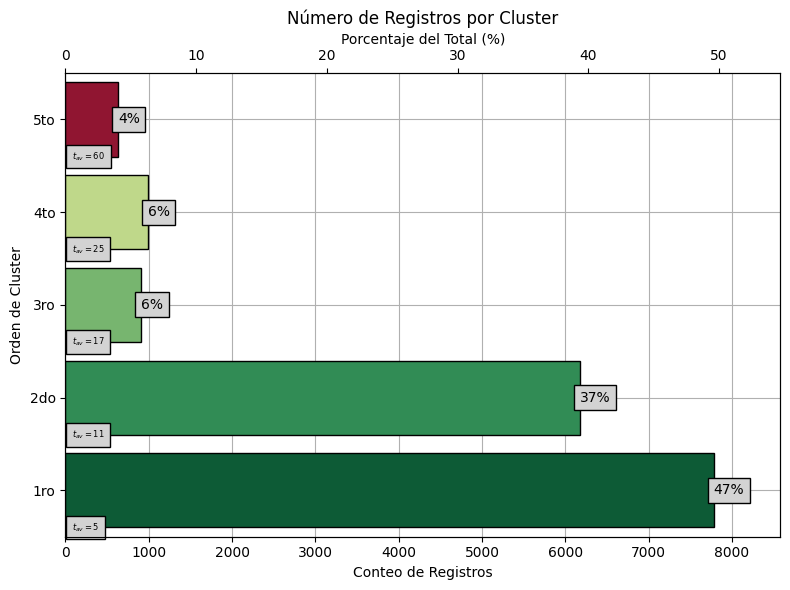

In [276]:
# Initialize figure with larger size
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Count the number of records for each cluster and invert the order
counts = gdf['cluster_name'].value_counts().loc[list(cluster_names.values())]

# Define the custom order of clusters (1st closest to 0, 5th farthest from the y-axis)
custom_order = counts.index.values[np.array([0, 1, 2, 3, 4])].sort()

# Generate horizontal bar plot with custom order
bars = sns.barplot(x=counts.values, y=counts.index, palette=color_dict_names, edgecolor='black', ax=ax, zorder=2, orient='horizontal', order=custom_order)

# Set labels and title
ax.set_xlabel('Conteo de Registros')
ax.set_ylabel('Orden de Cluster')
ax.set_title('Número de Registros por Cluster')

# Add grid
ax.grid(True, zorder=1)

# Create a second x-axis
ax2 = ax.twiny()

# Calculate the percentages for each cluster
percentages = 100 * counts.values / counts.sum()

# Set the limits for the first x-axis
ax.set_xlim(0, 1.05 * ax.get_xlim()[1])

# Set the limits for the second x-axis
ax2.set_xlim(0, 1.05 * 100 * (ax.get_xlim()[1] / counts.sum()))
ax2.set_xlabel('Porcentaje del Total (%)')

# Annotate bars with their corresponding percentages
for i, bar in enumerate(bars.patches):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{percentages[i]:.0f}%',
            ha='left', va='center', color='black', bbox=dict(facecolor='lightgray', edgecolor='black'),
            fontsize=10)

# Add horizontal lines for the mean of each cluster
for i, bar in enumerate(bars.patches):
    mean = gdf.loc[gdf['cluster_name'] == cluster_names[i], 'Tiempo Promedio'].mean()
    ax.text(80, bar.get_y() + bar.get_height(), f'$t_{{av}}={mean:.0f}$',
            ha='left', va='center', color='black', bbox=dict(facecolor='lightgray', edgecolor='black'),
            fontsize=6)

# Show the plot
plt.tight_layout()
plt.show()
